In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-18 15:42:33.414534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 15:42:33.415627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 15:42:33.416006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)


L355
2024-01-18 15:42:33.417445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 15:42:33.417859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 46872 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:07:00.0, compute capability: 8.6


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
feats shape:  (9587, 8)


In [11]:
# dimensions of MP are the index 1 and 2 of column in feat
dim_lh = feats[:, 1:3]

max_lh = dim_lh.max(axis=0)
# normalize dim_lh based on max value of each column
dim_lh = dim_lh / max_lh

dim_lh


array([[0.11637931, 0.13836478],
       [0.11206897, 0.1572327 ],
       [0.14224138, 0.13836478],
       ...,
       [0.87068966, 0.47798742],
       [0.87068966, 0.47798742],
       [0.85344828, 0.48427673]])

In [12]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
# expand the dimension of x to 4D
manta = np.expand_dims(manta, axis=3)
xiris = np.expand_dims(xiris, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (9587, 320, 320, 2)
y shape:  (9587, 2)


In [13]:


# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x_train shape:  (7669, 320, 320, 2)
y_train shape:  (7669, 2)
x_test shape:  (1918, 320, 320, 2)
y_test shape:  (1918, 2)


In [14]:
del manta, xiris, y, dim_lh, x

In [17]:
def build_simpleCNN_model(resolution, n_channels, n_classes):
    """
        Build a simple CNN model with 2 convolutional layers, 2 max pooling layers, 1 fully connected layer and 1 output layer.
        The model is built using the Keras functional API.
        The model is compiled with the Adam optimizer and the categorical cross entropy loss function.
    """
    
    # Define the input shape
    """ input_shape = Input(shape=(resolution, resolution, n_channels))
    x = Conv2D(16, (3, 3), activation='relu')(input_shape) # 32
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu')(x) # 64
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x) # 64
    x = MaxPooling2D(pool_size=(2, 2))(x) """
    inputs = Input(shape=(resolution, resolution, n_channels))
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    x = Flatten()(x)
    #x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    output_l = Dense(1, activation="linear", name="lenght")(x)
    output_h = Dense(1, activation="linear", name="height")(x)
    

    # Define the model with the specified input and outputs
    model = Model(inputs=inputs, outputs=[output_l, output_h])
    return model

In [18]:
# build model
resolution = X_test.shape[1]
n_channels = X_test.shape[3]
n_classes = y_test.shape[1]

battch_size = 32
epochs = 40
validation_split = 0.2
learning_rate = 0.0001

print("resolution: ", resolution)
print("n_channels: ", n_channels)
print("n_classes: ", n_classes)

# build model
model = build_simpleCNN_model(resolution, n_channels, n_classes)

# compile model
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse') #, metrics=['mse'])  # Using Mean Squared Error (mse) as the loss
# print model summary
model.summary()


# train model
history = model.fit(x=X_train,
                    y=[y_train[:, 0], y_train[:, 1]],
                    batch_size=battch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=validation_split)


resolution:  320
n_channels:  2
n_classes:  2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 2)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 318, 318, 16)         304       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 159, 159, 16)         0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 157, 157, 32)         4640      ['max_pooling2d_6[0][0]'] 

2024-01-18 15:57:53.876644: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-18 15:57:54.017492: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 15:57:54.610733: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 15:57:55.378296: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f08992e6120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 15:57:55.378343: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-18 15:57:55.394336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705593475.569936 1582420 device_compiler.h:186] 

192/192 [==============================] - 17s 55ms/step - loss: 0.1670 - lenght_loss: 0.0972 - height_loss: 0.0699 - val_loss: 0.0011 - val_lenght_loss: 7.1372e-04 - val_height_loss: 3.9945e-04
Epoch 2/40
192/192 [==============================] - 6s 33ms/step - loss: 9.5438e-04 - lenght_loss: 4.9028e-04 - height_loss: 4.6410e-04 - val_loss: 7.0012e-04 - val_lenght_loss: 3.8705e-04 - val_height_loss: 3.1307e-04
Epoch 3/40
192/192 [==============================] - 6s 34ms/step - loss: 8.0280e-04 - lenght_loss: 4.2973e-04 - height_loss: 3.7307e-04 - val_loss: 7.0438e-04 - val_lenght_loss: 4.5705e-04 - val_height_loss: 2.4733e-04
Epoch 4/40
192/192 [==============================] - 7s 34ms/step - loss: 5.9847e-04 - lenght_loss: 3.0176e-04 - height_loss: 2.9671e-04 - val_loss: 5.7862e-04 - val_lenght_loss: 3.8747e-04 - val_height_loss: 1.9114e-04
Epoch 5/40
192/192 [==============================] - 6s 34ms/step - loss: 4.6825e-04 - lenght_loss: 2.1547e-04 - height_loss: 2.5279e-04 - va

In [19]:
# save model
#model.save("simpleCNN_model.h5")

In [20]:
# evaluate model
score = model.evaluate(X_test, [y_test[:, 0], y_test[:, 1]], verbose=0)
print(score)

[0.00031153394957073033, 0.0001590075989952311, 0.00015252629236783832]


60/60 [==============================] - 1s 15ms/step
r2 score:  0.9969902911156626 0.9860224944751889


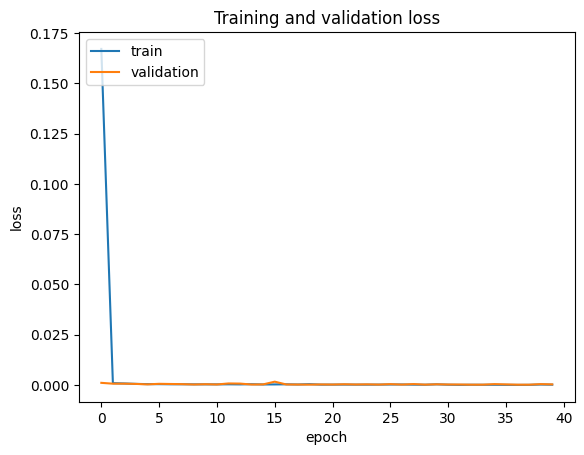

In [21]:
# eval regression model
from sklearn.metrics import r2_score

y_pred_l, y_pred_h = model.predict(X_test)
r2_l = r2_score(y_test[:,0], y_pred_l)
r2_h = r2_score(y_test[:,1], y_pred_h)
print("r2 score: ", r2_l, r2_h)

# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


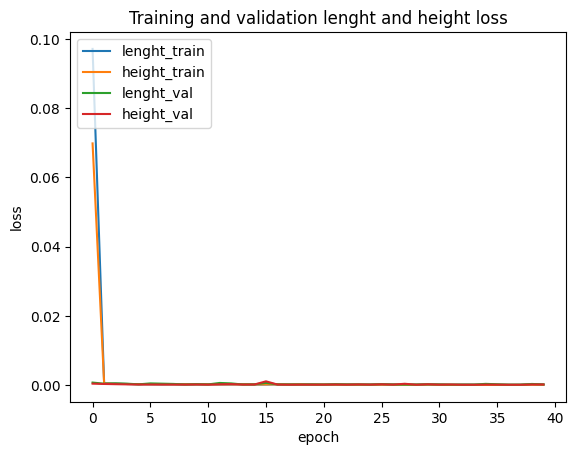

In [22]:
# plot lenght_loss and height_loss during training and validation
plt.plot(history.history['lenght_loss'])
plt.plot(history.history['height_loss'])
plt.plot(history.history['val_lenght_loss'])
plt.plot(history.history['val_height_loss'])
plt.title('Training and validation lenght and height loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['lenght_train', 'height_train', 'lenght_val', 'height_val'], loc='upper left')
plt.show()
 

In [23]:
# make a black image with the same shape as X_test[0]
black_image = np.zeros(X_test[0].shape[0])
print(black_image.shape)

# replace the second channel with the black image 
X_test_new = np.copy(X_test)
X_test_new[:, :, :, 1] = black_image

""" x = X_test_new[10]
# plot first and second channel of x
plt.imshow(x[:, :, 0])
plt.show()
plt.imshow(x[:, :, 1])
plt.show()
 """

(320,)


' x = X_test_new[10]\n# plot first and second channel of x\nplt.imshow(x[:, :, 0])\nplt.show()\nplt.imshow(x[:, :, 1])\nplt.show()\n '

In [24]:
y_pred_l_new, y_pred_h_new = model.predict(X_test_new)
r2_l_new = r2_score(y_test[:,0], y_pred_l_new)
r2_h_new = r2_score(y_test[:,1], y_pred_h_new)

print("r2 score: ", r2_l_new, r2_h_new)

60/60 [==============================] - 1s 15ms/step
r2 score:  -7.109014187820108 -16.331621485604416


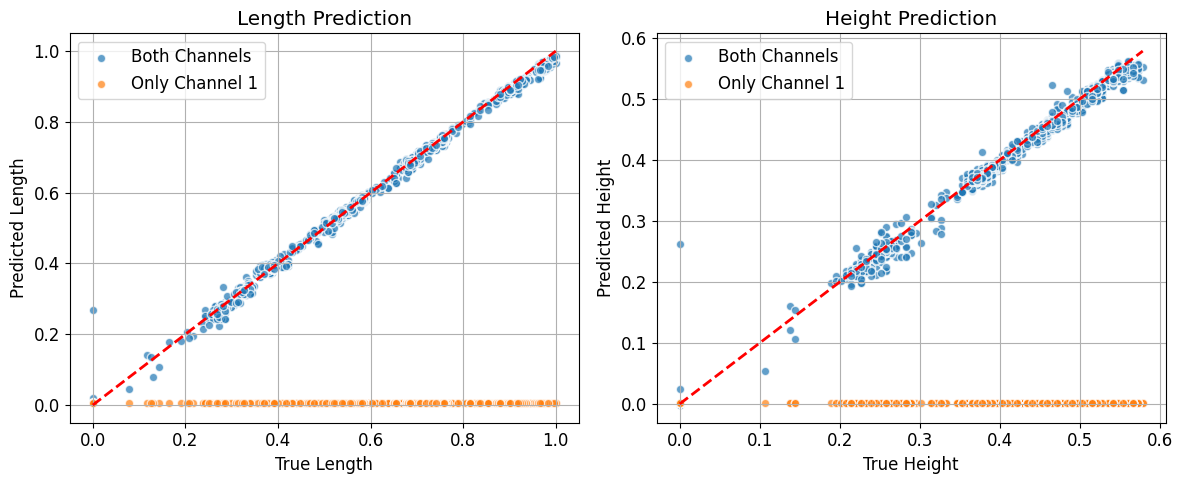

In [25]:
import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 0], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test[:, 0], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 1], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test[:, 1], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



60/60 [==============================] - 1s 14ms/step


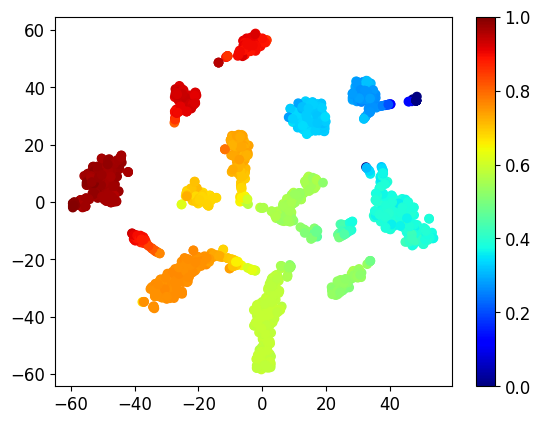

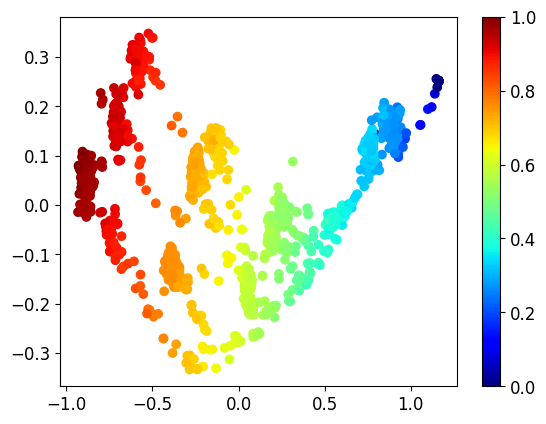

60/60 [==============================] - 1s 13ms/step


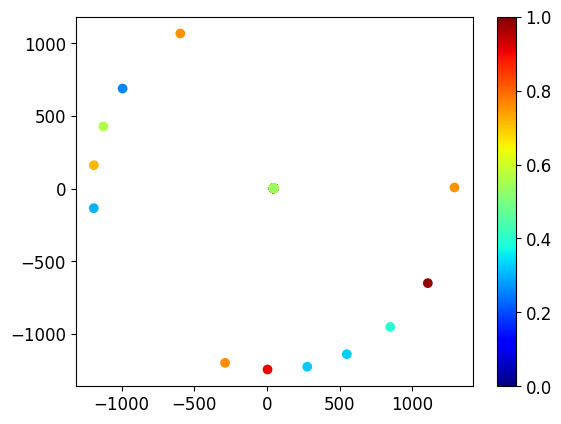

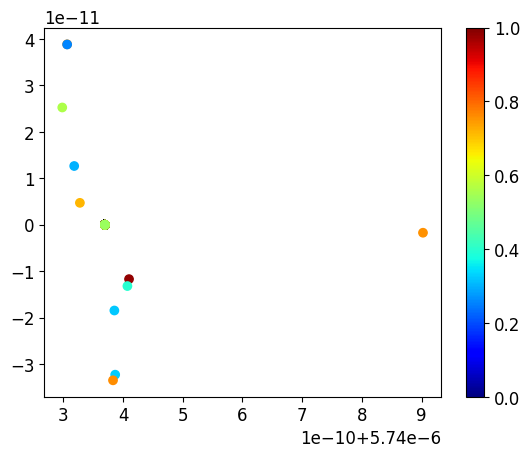

In [38]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def eval_tsne_pca(model, x_test, plot=True):
    # Assuming 'model' is your trained regression model and 'data' is your input data
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE or PCA
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    # apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    return tsne_results, pca_results

tsne_results, pca_results = eval_tsne_pca(model, X_test, plot=True)

# eval for X_test_new
tsne_results, pca_results = eval_tsne_pca(model, X_test_new, plot=True)

    